In [1]:
from tile_mate.stitcher import get_all_tile_data, get_tile_data, DATASET_SHORTNAMES, SEASONS
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import numpy as np
import concurrent.futures
from osgeo import gdal

In [2]:
DATASET_SHORTNAMES, SEASONS

(['peckel_water_occ_2021',
  'esa_world_cover_2020',
  'esa_world_cover_2021',
  'hansen_annual_mosaic',
  's1_coherence_2020',
  'cop_100_lulc_discrete'],
 ['fall', 'winter', 'spring', 'summer'])

# Parameters

In [3]:
TEMPORAL_BASELINE = 12 # 6 days do not have enough coverage

# Directory Setup

In [4]:
OUT_DIR = Path(f'average_coherence_over_season_with_{TEMPORAL_BASELINE}_day_temporal_baseline')
OUT_DIR.mkdir(exist_ok=True, parents=True)

# Read Geographic Data and Tile Data

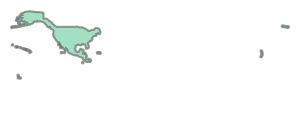

In [5]:
df_na = gpd.read_file('https://github.com/OPERA-Cal-Val/DSWx-Validation-Experiments/blob/main/marshak/north_america_boundaries/north_america_opera_with_sub_zone.geojson?raw=True')
na_geo = df_na.geometry.unary_union.buffer(1)
na_geo

In [7]:
df_coast = gpd.read_file('https://github.com/martynafford/natural-earth-geojson/blob/master/110m/physical/ne_110m_coastline.json?raw=True')

In [8]:
dfs = [get_tile_data('s1_coherence_2020', season=season, temporal_baseline_days=TEMPORAL_BASELINE) for season in tqdm(SEASONS)]

100%|███████████████████████████████████| 4/4 [00:10<00:00,  2.63s/it]


In [9]:
inds = [df.geometry.intersects(na_geo) for df in tqdm(dfs)]
dfs_filt = [df[ind].reset_index(drop=True) for df, ind in zip(dfs, inds)]

100%|███████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


<Axes: >

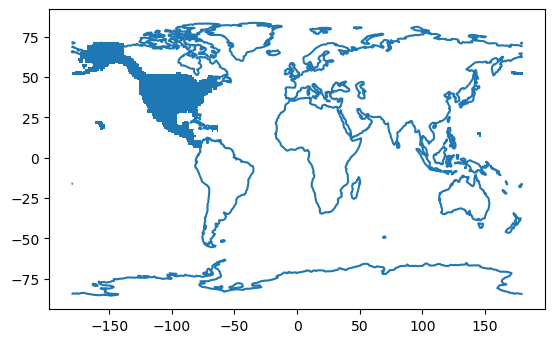

In [10]:
fig, ax = plt.subplots()
df_coast.plot(ax=ax)
dfs_filt[0].plot(ax=ax)
#df_na.plot(ax=ax, color='yellow', alpha=.2)
#dfs[0].plot(ax=ax)

# Tiles across seasons are not available

In [11]:
for df in dfs_filt:
    print(df.shape)

(2360, 5)
(2351, 5)
(2358, 5)
(2357, 5)


In [12]:
all_tile_ids = [tile_id for df in dfs_filt for tile_id in df.tile_id]
all_tile_ids = sorted(list(set(all_tile_ids)))
len(all_tile_ids)

2361

# Merge Dataframes

In [13]:
dfs_filt_tmp = [df[['tile_id', 'url']].rename(columns={'url': f'url_{season}'}) for (df, season) in zip(dfs_filt, SEASONS)]
dfs_filt_tmp[3].head()

,tile_id,url_summer
0,N07W077,https://sentinel-1-global-coherence-earthbigda...
1,N07W078,https://sentinel-1-global-coherence-earthbigda...
2,N07W079,https://sentinel-1-global-coherence-earthbigda...
3,N07W080,https://sentinel-1-global-coherence-earthbigda...
4,N07W081,https://sentinel-1-global-coherence-earthbigda...


In [14]:
from functools import reduce

def merge_on_id(df_left, df_right):
    
    return pd.merge(df_left,
                    df_right,
                    on=['tile_id'], 
                    how='outer')
    
df_merged = (reduce(merge_on_id, dfs_filt_tmp))
df_merged.head()

,tile_id,url_fall,url_winter,url_spring,url_summer
0,N07W077,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...
1,N07W078,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...
2,N07W079,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...
3,N07W080,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...
4,N07W081,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...,https://sentinel-1-global-coherence-earthbigda...


In [15]:
ind = df_merged.url_fall.isnull()
df_merged[ind]

,tile_id,url_fall,url_winter,url_spring,url_summer
2360,N14E144,NaN,https://sentinel-1-global-coherence-earthbigda...,NaN,NaN


## Aggregate by tiles

Going to round to nearest int.

In [16]:
records = df_merged.to_dict('records')
records[0]

{'tile_id': 'N07W077',
 'url_fall': 'https://sentinel-1-global-coherence-earthbigdata.s3.us-west-2.amazonaws.com/data/tiles/N07W077/N07W077_fall_vv_COH12.tif',
 'url_winter': 'https://sentinel-1-global-coherence-earthbigdata.s3.us-west-2.amazonaws.com/data/tiles/N07W077/N07W077_winter_vv_COH12.tif',
 'url_spring': 'https://sentinel-1-global-coherence-earthbigdata.s3.us-west-2.amazonaws.com/data/tiles/N07W077/N07W077_spring_vv_COH12.tif',
 'url_summer': 'https://sentinel-1-global-coherence-earthbigdata.s3.us-west-2.amazonaws.com/data/tiles/N07W077/N07W077_summer_vv_COH12.tif'}

In [17]:
def open_one(url: str) -> tuple:
    with rasterio.open(url) as ds:
        X = ds.read(1)
        p = ds.profile
    return X, p
    
def avg_data_by_tile(record: dict) -> Path:
    url_keys = [key for key in record.keys() if 'url' in key]
    urls = [record[url_key] for url_key in url_keys if isinstance(record[url_key], str)]
    
    data = list(map(open_one, urls))
    Xs, ps = list(zip(*data))

    X_avg = np.nanmean(Xs, axis=0).round().astype(int)
    p = ps[0]
    return X_avg, p

In [18]:
X, p = avg_data_by_tile(records[0])

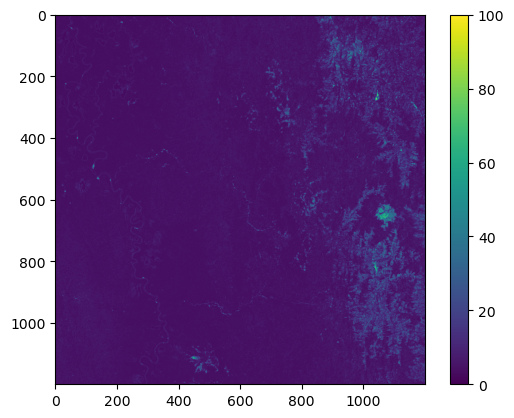

In [19]:
plt.imshow(X)
plt.colorbar()

In [20]:
def write_one_avg_by_tile(record: dict) -> Path:
    X_avg, p = avg_data_by_tile(record)
    tile_id = record['tile_id']
    out_path = OUT_DIR / f'{tile_id}.tif'
    with rasterio.open(out_path, 'w', **p) as ds:
        ds.write(X_avg, 1)
    return out_path

In [21]:
#paths = list(map(write_one_avg_by_tile, tqdm(records[:])))

In [22]:
with concurrent.futures.ProcessPoolExecutor(max_workers=20) as executor:
    paths = list(tqdm(executor.map(write_one_avg_by_tile, records[:]), total=len(records)))

100%|█████████████████████████████| 2361/2361 [05:18<00:00,  7.42it/s]


In [23]:
paths[:10]

[PosixPath('average_coherence_over_season_with_12_day_temporal_baseline/N07W077.tif'),
 PosixPath('average_coherence_over_season_with_12_day_temporal_baseline/N07W078.tif'),
 PosixPath('average_coherence_over_season_with_12_day_temporal_baseline/N07W079.tif'),
 PosixPath('average_coherence_over_season_with_12_day_temporal_baseline/N07W080.tif'),
 PosixPath('average_coherence_over_season_with_12_day_temporal_baseline/N07W081.tif'),
 PosixPath('average_coherence_over_season_with_12_day_temporal_baseline/N07W082.tif'),
 PosixPath('average_coherence_over_season_with_12_day_temporal_baseline/N07W083.tif'),
 PosixPath('average_coherence_over_season_with_12_day_temporal_baseline/N08W077.tif'),
 PosixPath('average_coherence_over_season_with_12_day_temporal_baseline/N08W078.tif'),
 PosixPath('average_coherence_over_season_with_12_day_temporal_baseline/N08W079.tif')]

In [24]:
out_vrt_path = OUT_DIR / f'_avg_coh_across_seasons.vrt'
paths_str = list(map(str, paths))
ds = gdal.BuildVRT(str(out_vrt_path), paths_str)

/mnt/leffe-data2/cmarshak/mambaforge/envs/s1_coherence/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [25]:
del ds

# Upload to AWS

In [26]:
import boto3

session = boto3.session.Session(profile_name='saml-pub')

S3_CLIENT = session.resource('s3')

In [27]:
COH_BUCKET='opera-s1-coherence-annual-avg-2020'

def upload_file_to_s3(path_to_file: str | Path, 
                      bucket: str, 
                      prefix: str = '') -> str:
    fn = Path(path_to_file).name
    s3_key = fn
    if prefix:
        s3_key = str(Path(prefix) / fn)

    # Upload the file to S3
    s3 = session.resource('s3')
    s3.Bucket(bucket).upload_file(path_to_file, s3_key)
    return f's3://{bucket}/{s3_key}'

def upload_file_to_s3_partial(path_to_file: str | Path) -> str:
    return upload_file_to_s3(path_to_file, COH_BUCKET)

In [28]:
with concurrent.futures.ProcessPoolExecutor(max_workers=50) as executor:
    s3_paths = list(tqdm(executor.map(upload_file_to_s3_partial, paths[:]), total=len(paths)))

100%|█████████████████████████████| 2361/2361 [00:23<00:00, 99.69it/s]


In [29]:
s3_paths[:3]

['s3://opera-s1-coherence-annual-avg-2020/N07W077.tif',
 's3://opera-s1-coherence-annual-avg-2020/N07W078.tif',
 's3://opera-s1-coherence-annual-avg-2020/N07W079.tif']

In [34]:
def extract_url(s3_path: str)-> str:
    tokens = s3_path.split('/')
    bucket = tokens[2]
    key = tokens[3]
    return f'https://{bucket}.s3.us-west-2.amazonaws.com/{key}'

In [35]:
urls_aws = [extract_url(s3_path) for s3_path in s3_paths]
urls_aws[:2]

['https://opera-s1-coherence-annual-avg-2020.s3.us-west-2.amazonaws.com/N07W077.tif',
 'https://opera-s1-coherence-annual-avg-2020.s3.us-west-2.amazonaws.com/N07W078.tif']

In [ ]:
# out_vrt_path = 'aws_avg_coh.vrt'
# aws_paths_str = list(map(str, urls_aws[:]))
# ds = gdal.BuildVRT(str(out_vrt_path), aws_paths_str)

In [ ]:
# del ds